# Stochastic Gradient Descent on simple function

[onnxruntime-training](https://github.com/microsoft/onnxruntime) is an extension onnxruntime or more precisely the same library compiled with different settings. It provides a way to compute a gradient of a function defined by an ONNX graph.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## A simple problem

Let's choose a simple regression problem defined by $z = -1 - 2x + 3y + \frac{1}{2}x^2 -\frac{1}{3} y^2 +\epsilon$ and we try to approximate by a function $f(x,y) = a + bx + cy + dx^2 +  ey^2$. Every coefficient is determined from an optimization problem solved with a stochastic gradient descent.

In [3]:
from typing import Any
import numpy
import mlprodict.npy.numpy_onnx_impl as npnx
from mlprodict.npy import onnxnumpy_default, NDArray


@onnxnumpy_default
def fct(x: NDArray[(None, 2), numpy.float32]) -> NDArray[(None, 1), numpy.float32]:
    coef_x = numpy.array([[-2, 3]], dtype=numpy.float32) 
    coef_x2 = numpy.array([[0.5, -0.33333]], dtype=numpy.float32)
    bias = numpy.array([-1], dtype=numpy.float32)
    poly = x * coef_x + x * x * coef_x2
    y = poly[:, 0] + poly[:, 1] + bias
    return y.reshape((-1, 1))


x = numpy.array([[0, 0], [1, 0], [0, 1], [1, 1], [2, 2]], dtype=numpy.float32)
fct(x)

array([[-1.        ],
       [-2.5       ],
       [ 1.6666701 ],
       [ 0.16667008],
       [ 1.6666799 ]], dtype=float32)

In [4]:
%onnxview fct.to_onnx()

In [5]:
from mlprodict.plotting.text_plot import onnx_simple_text_plot
print(onnx_simple_text_plot(fct.to_onnx()))

opset: domain='' version=14
input: name='x' type=dtype('float32') shape=(0, 2)
init: name='init' type=dtype('float32') shape=(0,) -- array([ 0.5    , -0.33333], dtype=float32)
init: name='init_1' type=dtype('float32') shape=(0,) -- array([-2.,  3.], dtype=float32)
init: name='init_2' type=dtype('int64') shape=(0,) -- array([1], dtype=int64)
init: name='init_3' type=dtype('int64') shape=(0,) -- array([2], dtype=int64)
init: name='init_5' type=dtype('int64') shape=(0,) -- array([0], dtype=int64)
init: name='init_b10' type=dtype('float32') shape=(0,) -- array([-1.], dtype=float32)
init: name='init_b11' type=dtype('int64') shape=(0,) -- array([-1,  1], dtype=int64)
Mul(x, x) -> out_mul_0
  Mul(out_mul_0, init) -> out_mul_0_1
Mul(x, init_1) -> out_mul_0_2
  Add(out_mul_0_2, out_mul_0_1) -> out_add_0
    Slice(out_add_0, init_2, init_3, init_2) -> out_sli_0
      Squeeze(out_sli_0, init_2) -> out_squ_0
    Slice(out_add_0, init_5, init_2, init_2) -> out_sli_0_1
      Squeeze(out_sli_0_1, ini

## Gradient : retropropagation

Let's look into the gradient.

In [6]:
from onnxcustom.training.grad_helper import onnx_derivative, DerivativeOptions

onx = fct.to_onnx()
grad = onnx_derivative(onx)
%onnxview grad

In [7]:
from mlprodict.plotting.text_plot import onnx_text_plot_io, onnx_simple_text_plot
print(onnx_text_plot_io(grad))

opset: domain='' version=14
opset: domain='com.microsoft.nchwc' version=1
opset: domain='ai.onnx.ml' version=2
opset: domain='com.ms.internal.nhwc' version=1
opset: domain='ai.onnx.training' version=1
opset: domain='ai.onnx.preview.training' version=1
opset: domain='com.microsoft' version=1
opset: domain='com.microsoft.experimental' version=1
input: name='x' type=dtype('float32') shape=(0, 2)
input: name='init' type=dtype('float32') shape=(1, 2)
input: name='init_1' type=dtype('float32') shape=(1, 2)
input: name='init_b10' type=dtype('float32') shape=(1,)
input: name='y_grad' type=dtype('float32') shape=(0, 1)
init: name='init_5' type=dtype('int64') shape=(0,)
init: name='init_2' type=dtype('int64') shape=(0,)
init: name='init_3' type=dtype('int64') shape=(0,)
output: name='x_grad' type=dtype('float32') shape=(0, 2)
output: name='init_grad' type=dtype('float32') shape=(1, 2)
output: name='init_1_grad' type=dtype('float32') shape=(1, 2)
output: name='init_b10_grad' type=dtype('float32')

In [8]:
from mlprodict.onnx_tools.onnx_manipulations import onnx_rename_names
renamed = onnx_rename_names(grad)

In [9]:
print(onnx_simple_text_plot(renamed))

opset: domain='' version=14
opset: domain='com.microsoft.nchwc' version=1
opset: domain='ai.onnx.ml' version=2
opset: domain='com.ms.internal.nhwc' version=1
opset: domain='ai.onnx.training' version=1
opset: domain='ai.onnx.preview.training' version=1
opset: domain='com.microsoft' version=1
opset: domain='com.microsoft.experimental' version=1
input: name='x' type=dtype('float32') shape=(0, 2)
input: name='init' type=dtype('float32') shape=(1, 2)
input: name='init_1' type=dtype('float32') shape=(1, 2)
input: name='init_b10' type=dtype('float32') shape=(1,)
input: name='y_grad' type=dtype('float32') shape=(0, 1)
init: name='i0' type=dtype('int64') shape=(0,) -- array([0], dtype=int64)
init: name='i1' type=dtype('int64') shape=(0,) -- array([1], dtype=int64)
init: name='i2' type=dtype('int64') shape=(0,) -- array([2], dtype=int64)
Mul(x, x) -> r0
  Mul(r0, init) -> r1
    Shape(r1) -> r32
Mul(x, init_1) -> r2
  Add(r2, r1) -> r3
    Slice(r3, i1, i2, i1) -> r4
      Squeeze(r4, i1) -> r5


In [10]:
set(n.op_type for n in grad.graph.node)

{'Add',
 'BroadcastGradientArgs',
 'Mul',
 'ReduceSum',
 'Reshape',
 'Shape',
 'Slice',
 'SliceGrad',
 'Squeeze',
 'Sum',
 'Unsqueeze'}

The resulting graph assumes the gradient for `y_grad` is known. That's the case for a layer in a neural network. In our case, this gradient should come from the loss. Let's add it to the graph.

## Add a square loss

In [11]:
from onnxcustom.utils.orttraining_helper import add_loss_output
onx_loss = add_loss_output(onx)

%onnxview onx_loss

In [12]:
print(onnx_simple_text_plot(onx_loss))

opset: domain='' version=14
input: name='x' type=dtype('float32') shape=(0, 2)
input: name='label' type=dtype('float32') shape=(0, 1)
init: name='init' type=dtype('float32') shape=(0,) -- array([ 0.5    , -0.33333], dtype=float32)
init: name='init_1' type=dtype('float32') shape=(0,) -- array([-2.,  3.], dtype=float32)
init: name='init_2' type=dtype('int64') shape=(0,) -- array([1], dtype=int64)
init: name='init_3' type=dtype('int64') shape=(0,) -- array([2], dtype=int64)
init: name='init_5' type=dtype('int64') shape=(0,) -- array([0], dtype=int64)
init: name='init_b10' type=dtype('float32') shape=(0,) -- array([-1.], dtype=float32)
init: name='init_b11' type=dtype('int64') shape=(0,) -- array([-1,  1], dtype=int64)
Mul(x, x) -> out_mul_0
  Mul(out_mul_0, init) -> out_mul_0_1
Mul(x, init_1) -> out_mul_0_2
  Add(out_mul_0_2, out_mul_0_1) -> out_add_0
    Slice(out_add_0, init_2, init_3, init_2) -> out_sli_0
      Squeeze(out_sli_0, init_2) -> out_squ_0
    Slice(out_add_0, init_5, init_2

The graph has 5 inputs: `x`, `label` or the expected target, and the weights and two outputs, the function output and the loss. We don't need the first one so we remove it.

In [13]:
from mlprodict.onnx_tools.onnx_manipulations import select_model_inputs_outputs

onx_loss_only = select_model_inputs_outputs(onx_loss, outputs=['loss'])
print(onnx_simple_text_plot(onx_loss_only))

opset: domain='' version=14
input: name='x' type=dtype('float32') shape=(0, 2)
input: name='label' type=dtype('float32') shape=(0, 1)
init: name='init' type=dtype('float32') shape=(0,) -- array([ 0.5    , -0.33333], dtype=float32)
init: name='init_1' type=dtype('float32') shape=(0,) -- array([-2.,  3.], dtype=float32)
init: name='init_2' type=dtype('int64') shape=(0,) -- array([1], dtype=int64)
init: name='init_3' type=dtype('int64') shape=(0,) -- array([2], dtype=int64)
init: name='init_5' type=dtype('int64') shape=(0,) -- array([0], dtype=int64)
init: name='init_b10' type=dtype('float32') shape=(0,) -- array([-1.], dtype=float32)
init: name='init_b11' type=dtype('int64') shape=(0,) -- array([-1,  1], dtype=int64)
Mul(x, x) -> out_mul_0
  Mul(out_mul_0, init) -> out_mul_0_1
Mul(x, init_1) -> out_mul_0_2
  Add(out_mul_0_2, out_mul_0_1) -> out_add_0
    Slice(out_add_0, init_5, init_2, init_2) -> out_sli_0_1
      Squeeze(out_sli_0_1, init_2) -> out_squ_0_1
    Slice(out_add_0, init_2, 

## Gradient again : loss + retropropagation

In [14]:
grad_loss = onnx_rename_names(onnx_derivative(
    onx_loss_only, options=DerivativeOptions.FillGrad | DerivativeOptions.KeepOutputs))
%onnxview grad_loss

In [15]:
print(onnx_simple_text_plot(grad_loss))

opset: domain='' version=14
opset: domain='com.microsoft.nchwc' version=1
opset: domain='ai.onnx.ml' version=2
opset: domain='com.ms.internal.nhwc' version=1
opset: domain='ai.onnx.training' version=1
opset: domain='ai.onnx.preview.training' version=1
opset: domain='com.microsoft' version=1
opset: domain='com.microsoft.experimental' version=1
input: name='x' type=dtype('float32') shape=(0, 2)
input: name='label' type=dtype('float32') shape=(0, 1)
input: name='init' type=dtype('float32') shape=(1, 2)
input: name='init_1' type=dtype('float32') shape=(1, 2)
input: name='init_b10' type=dtype('float32') shape=(1,)
init: name='i0' type=dtype('int64') shape=(0,) -- array([-1,  1], dtype=int64)
init: name='i1' type=dtype('int64') shape=(0,) -- array([0], dtype=int64)
init: name='i2' type=dtype('int64') shape=(0,) -- array([1], dtype=int64)
init: name='i3' type=dtype('int64') shape=(0,) -- array([2], dtype=int64)
Mul(x, init_1) -> r0
  Shape(r0) -> r47
Mul(x, x) -> r1
  Mul(r1, init) -> r2
  Ad

Let's compute the gradient.

In [16]:
x

array([[0., 0.],
       [1., 0.],
       [0., 1.],
       [1., 1.],
       [2., 2.]], dtype=float32)

In [17]:
y = fct(x)
y

array([[-1.        ],
       [-2.5       ],
       [ 1.6666701 ],
       [ 0.16667008],
       [ 1.6666799 ]], dtype=float32)

In [18]:
from mlprodict.onnxrt import OnnxInference

oinf = OnnxInference(grad_loss, runtime='onnxruntime1')

In [19]:
import pprint

init = numpy.array([[2, 3]], dtype=numpy.float32)
init_1 = numpy.array([[0.5, 0.33333]], dtype=numpy.float32)
init_b10 = numpy.array([1], dtype=numpy.float32)
result = oinf.run({'x': x, 'label': y, 
                   'init': init, 'init_1': init_1, 'init_b10': init_b10})
pprint.pprint(result)

{'init_1_grad': array([[109.333244, 102.666565]], dtype=float32),
 'init_b10_grad': array([76.6666], dtype=float32),
 'init_grad': array([[193.33316, 186.66649]], dtype=float32),
 'label_grad': array([[ -4.      ],
       [-12.      ],
       [ -5.33332 ],
       [-13.333321],
       [-41.99996 ]], dtype=float32),
 'loss': array([[532.5546]], dtype=float32),
 'x_grad': array([[  2.      ,   1.33332 ],
       [ 54.      ,   3.99996 ],
       [  2.66666 ,  33.777676],
       [ 59.999943,  84.44432 ],
       [356.99966 , 517.9994  ]], dtype=float32)}


We could use this gradient to implement a stochastic gradient descent in python. Two comments:
* If we implement it this with numpy, it cannot work on GPU.
* If we use OrtValue (tensor from onnxruntime), how to do simple addition between OrtValue ?

We need to implemented the second option. A simple addition between two OrtValue must be done with an ONNX graph.

## TrainingSession

In [20]:
X = numpy.random.randn(100, 2).astype(numpy.float32) / 10
y = fct(X) + (numpy.random.randn(100, 1) / 1000).astype(numpy.float32)
X.shape, y.shape

((100, 2), (100, 1))

In [21]:
print(onnx_simple_text_plot(onx))

opset: domain='' version=14
input: name='x' type=dtype('float32') shape=(0, 2)
init: name='init' type=dtype('float32') shape=(0,) -- array([ 0.5    , -0.33333], dtype=float32)
init: name='init_1' type=dtype('float32') shape=(0,) -- array([-2.,  3.], dtype=float32)
init: name='init_2' type=dtype('int64') shape=(0,) -- array([1], dtype=int64)
init: name='init_3' type=dtype('int64') shape=(0,) -- array([2], dtype=int64)
init: name='init_5' type=dtype('int64') shape=(0,) -- array([0], dtype=int64)
init: name='init_b10' type=dtype('float32') shape=(0,) -- array([-1.], dtype=float32)
init: name='init_b11' type=dtype('int64') shape=(0,) -- array([-1,  1], dtype=int64)
Mul(x, x) -> out_mul_0
  Mul(out_mul_0, init) -> out_mul_0_1
Mul(x, init_1) -> out_mul_0_2
  Add(out_mul_0_2, out_mul_0_1) -> out_add_0
    Slice(out_add_0, init_2, init_3, init_2) -> out_sli_0
      Squeeze(out_sli_0, init_2) -> out_squ_0
    Slice(out_add_0, init_5, init_2, init_2) -> out_sli_0_1
      Squeeze(out_sli_0_1, ini

In [22]:
from onnxcustom.training.optimizers import OrtGradientOptimizer

train_session = OrtGradientOptimizer(
    onx_loss, ['init', 'init_1', 'init_b10'], learning_rate=1e-1,
    batch_size=5, max_iter=100)

train_session.fit(X, y)

OrtGradientOptimizer(model_onnx='ir_version...', weights_to_train=['init', 'init_1', 'init_b10'], loss_output_name='loss', max_iter=100, training_optimizer_name='SGDOptimizer', batch_size=5, learning_rate=LearningRateSGD(eta0=0.1, alpha=0.0001, power_t=0.25, learning_rate='invscaling'), value=0.03162277660168379, device='cpu', warm_start=False, verbose=0, validation_every=10, saved_gradient=None, sample_weight_name='weight')

In [23]:
train_session.trained_coef_

{'init': array([[-0.34785354,  1.1399053 ]], dtype=float32),
 'init_1': array([[-1.9156165,  2.4292002]], dtype=float32),
 'init_b10': array([-1.0016667], dtype=float32)}

In [24]:
train_session.train_losses_[-5:]

[0.0036812867, 0.0038135047, 0.0037041684, 0.0037206002, 0.0032002896]

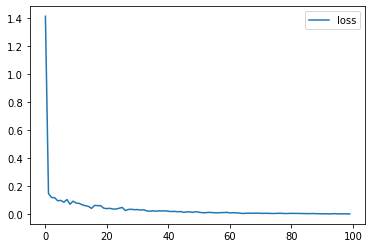

In [25]:
import pandas

pandas.DataFrame({'loss': train_session.train_losses_}).plot();

## Fordward backward: TrainingAgent

This second implementation uses [TrainingAgent](http://www.xavierdupre.fr/app/onnxcustom/helpsphinx/api/onnxruntime_python/training_partial.html#trainingagent).

In [26]:
from onnxcustom.training.optimizers_partial import OrtGradientForwardBackwardOptimizer

train_session = OrtGradientForwardBackwardOptimizer(
    onx, ['init', 'init_1', 'init_b10'], learning_rate=1e-1, 
    batch_size=2, max_iter=100)

In [27]:
train_session.fit(X, y)

OrtGradientForwardBackwardOptimizer(model_onnx='ir_version...', weights_to_train=['init', 'init_1', 'init_b10'], loss_output_name='loss', max_iter=100, training_optimizer_name='SGDOptimizer', batch_size=2, learning_rate=LearningRateSGD(eta0=0.1, alpha=0.0001, power_t=0.25, learning_rate='invscaling'), value=0.03162277660168379, device='cpu', warm_start=False, verbose=0, validation_every=10, learning_loss=SquareLearningLoss(), enable_logging=False, weight_name=None, learning_penalty=NoLearningPenalty(), exc=True)

In [28]:
train_session.train_losses_[-5:]

[0.00040441833, 0.00037421435, 0.00049950054, 0.00042527347, 0.00031072882]

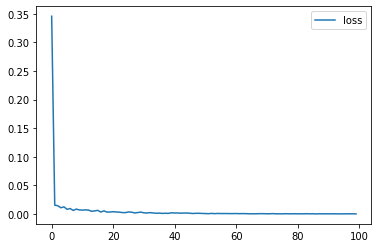

In [29]:
pandas.DataFrame({'loss': train_session.train_losses_}).plot();

In [30]:
train_session.trained_coef_

{'init': <onnxruntime.capi.onnxruntime_pybind11_state.OrtValue at 0x162a9199fb0>,
 'init_1': <onnxruntime.capi.onnxruntime_pybind11_state.OrtValue at 0x162a91a20f0>,
 'init_b10': <onnxruntime.capi.onnxruntime_pybind11_state.OrtValue at 0x162a91a2030>}

In [31]:
{k: v.numpy() for k, v in train_session.trained_coef_.items()}

{'init': array([[-0.35357383,  0.6850407 ]], dtype=float32),
 'init_1': array([[-1.916494 ,  2.8799832]], dtype=float32),
 'init_b10': array([-1.0036615], dtype=float32)}

Not the same weights? What about the prediction?

In [32]:
trained_onx = train_session.get_trained_onnx()

In [33]:
print(onnx_simple_text_plot(trained_onx))

opset: domain='' version=14
input: name='x' type=dtype('float32') shape=(0, 2)
init: name='init' type=dtype('float32') shape=(0,) -- array([-0.35357383,  0.6850407 ], dtype=float32)
init: name='init_1' type=dtype('float32') shape=(0,) -- array([-1.916494 ,  2.8799832], dtype=float32)
init: name='init_2' type=dtype('int64') shape=(0,) -- array([1], dtype=int64)
init: name='init_3' type=dtype('int64') shape=(0,) -- array([2], dtype=int64)
init: name='init_5' type=dtype('int64') shape=(0,) -- array([0], dtype=int64)
init: name='init_b10' type=dtype('float32') shape=(0,) -- array([-1.0036615], dtype=float32)
init: name='init_b11' type=dtype('int64') shape=(0,) -- array([-1,  1], dtype=int64)
Mul(x, x) -> out_mul_0
  Mul(out_mul_0, init) -> out_mul_0_1
Mul(x, init_1) -> out_mul_0_2
  Add(out_mul_0_2, out_mul_0_1) -> out_add_0
    Slice(out_add_0, init_2, init_3, init_2) -> out_sli_0
      Squeeze(out_sli_0, init_2) -> out_squ_0
    Slice(out_add_0, init_5, init_2, init_2) -> out_sli_0_1
   

In [34]:
oinf = OnnxInference(trained_onx)
oinf.run({'x': X})['y'][:5]

array([[-0.6123954],
       [-1.303561 ],
       [-2.0257921],
       [-1.2778704],
       [-0.9708453]], dtype=float32)

In [35]:
y[:5]

array([[-0.58675164],
       [-1.3148587 ],
       [-2.0666485 ],
       [-1.272753  ],
       [-0.95404863]], dtype=float32)

It works.

## MLPregressor

In [36]:
import warnings
import time
import numpy
import matplotlib.pyplot as plt
from pandas import DataFrame
from onnxruntime import get_device
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from skl2onnx import to_onnx


X, y = make_regression(1000, n_features=100, bias=2)
X = X.astype(numpy.float32)
y = y.astype(numpy.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [37]:
batch_size = 15
max_iter = 100

nn = MLPRegressor(hidden_layer_sizes=(50, 10), max_iter=max_iter,
                  solver='sgd', learning_rate_init=5e-5,
                  n_iter_no_change=max_iter * 3, batch_size=batch_size,
                  learning_rate="invscaling",
                  # default values
                  momentum=0.9, nesterovs_momentum=True, power_t=0.5)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    nn.fit(X_train, y_train)

Conversion to ONNX

In [38]:
from onnxcustom.utils.onnx_helper import onnx_rename_weights
onx = to_onnx(nn, X_train[:1].astype(numpy.float32), target_opset=15)
onx = onnx_rename_weights(onx)

In [39]:
train_session = OrtGradientForwardBackwardOptimizer(
    onx, device='cpu', learning_rate=5e-5,
    warm_start=False, max_iter=max_iter, batch_size=batch_size)

In [40]:
train_session.fit(X_train, y_train)

OrtGradientForwardBackwardOptimizer(model_onnx='ir_version...', weights_to_train="['I0_coeff...", loss_output_name='loss', max_iter=100, training_optimizer_name='SGDOptimizer', batch_size=15, learning_rate=LearningRateSGD(eta0=5e-05, alpha=0.0001, power_t=0.25, learning_rate='invscaling'), value=1.5811388300841898e-05, device='cpu', warm_start=False, verbose=0, validation_every=10, learning_loss=SquareLearningLoss(), enable_logging=False, weight_name=None, learning_penalty=NoLearningPenalty(), exc=True)

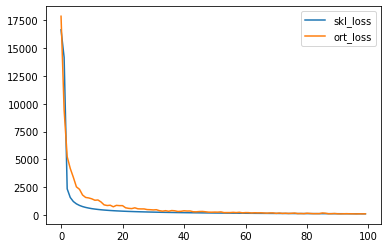

In [41]:
pandas.DataFrame(dict(skl_loss=nn.loss_curve_, ort_loss=train_session.train_losses_)).plot();

In [42]:
%timeit -n 1 -r 1 nn.fit(X_train, y_train)

C:\Python395_x64\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


1.98 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [43]:
%timeit -n 1 -r 1 train_session.fit(X_train, y_train)

1.88 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Not exactly the same: Nesterov?

In [44]:
from onnxcustom.training.sgd_learning_rate import LearningRateSGDNesterov

train_session2 = OrtGradientForwardBackwardOptimizer(
    onx, device='cpu', warm_start=False, max_iter=max_iter, batch_size=batch_size,
    learning_rate=LearningRateSGDNesterov(1e-5, nesterov=True, momentum=0.9))

In [45]:
train_session2.fit(X_train, y_train)

OrtGradientForwardBackwardOptimizer(model_onnx='ir_version...', weights_to_train="['I0_coeff...", loss_output_name='loss', max_iter=100, training_optimizer_name='SGDOptimizer', batch_size=15, learning_rate=LearningRateSGDNesterov(eta0=1e-05, alpha=0.0001, power_t=0.25, learning_rate='invscaling', momentum=0.9, nesterov=True), value=3.162277660168379e-06, device='cpu', warm_start=False, verbose=0, validation_every=10, learning_loss=SquareLearningLoss(), enable_logging=False, weight_name=None, learning_penalty=NoLearningPenalty(), exc=True)

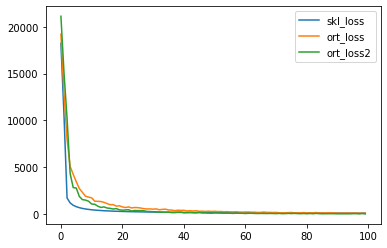

In [46]:
pandas.DataFrame(dict(skl_loss=nn.loss_curve_, 
                      ort_loss=train_session.train_losses_,
                      ort_loss2=train_session2.train_losses_)).plot();

In [47]:
%timeit -n 1 -r 1 train_session2.fit(X_train, y_train)

2.26 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Profiling

In [48]:
def clean_name(text):
    pos = text.find('onnxruntime')
    if pos >= 0:
        return text[pos:]
    pos = text.find('sklearn')
    if pos >= 0:
        return text[pos:]
    pos = text.find('onnxcustom')
    if pos >= 0:
        return text[pos:]
    pos = text.find('site-packages')
    if pos >= 0:
        return text[pos:]
    return text

from pyquickhelper.pycode.profiling import profile, profile2graph

ps = profile(lambda:train_session2.fit(X, y))[0]
root, nodes = profile2graph(ps, clean_text=clean_name)
text = root.to_text()
print(text)

<lambda>                                                     --       1       1 -- 0.00001 3.78074 -- <ipython-input-81-1255a3a5f723>:18:<lambda> (<lambda>)
    fit                                                      --       1       1 -- 0.00181 3.78073 -- onnxcustom/onnxcustom/training/optimizers_partial.py:263:fit (fit)
        __init__                                             --       1       1 -- 0.00002 0.00003 -- onnxcustom/onnxcustom/training/data_loader.py:26:__init__ (__init__)
            get_ort_device                                   --       1       1 -- 0.00000 0.00000 -- onnxruntime_helper.py:55:get_ort_device (get_ort_device)
            numpy_to_ort_value                               --       2       2 -- 0.00000 0.00001 -- onnxruntime_helper.py:120:numpy_to_ort_value (numpy_to_ort_value) +++
        needs_grad                                           --       3       3 -- 0.00001 0.00001 -- onnxcustom/onnxcustom/training/optimizers_partial.py:99:needs_grad (ne

        <built-in method builtins.isinstance>                --   53600   53600 -- 0.00548 0.00548 -- ~:0:<built-in method builtins.isinstance> (<built-in method builtins.isinstance>) +++


```
        _iteration                                           --     100     100 -- 0.41903 3.74610 -- 
            iter_ortvalue                                    --    6800    6800 -- 0.02838 0.14761 -- 
                _next_iter                                   --    6700    6700 -- 0.00946 0.07207 -- 
                    <built-in method builtins.len>           --    6700    6700 -- 0.00245 0.00423 -- 
                    <method 'randint' o...domState' objects> --    6700    6700 -- 0.05838 0.05838 -- 
                numpy_to_ort_value                           --   13400   13400 -- 0.00658 0.03860 -- 
                <built-in method builtins.len>               --    6900    6900 -- 0.00467 0.00855 -- 
            forward                                          --    6700    6700 -- 0.31685 0.44643 -- 
                input_to_ort                                 --    6700    6700 -- 0.08002 0.11492 -- 
                save_for_backward                            --    6700    6700 -- 0.01032 0.01032 -- 
                <method 'append' of 'list' objects>          --    6700    6700 -- 0.00434 0.00434 -- 
            backward                                         --    6700    6700 -- 0.43012 0.48957 -- 
                input_to_ort                                 --    6700    6700 -- 0.04148 0.05262 -- 
                saved_tensors                                --    6700    6700 -- 0.00207 0.00207 -- 
                <method 'pop' of 'list' objects>             --    6700    6700 -- 0.00476 0.00476 -- 
            loss_gradient                                    --    6700    6700 -- 0.05841 0.26967 -- 
                clear_binding_inputs                         --    6700    6700 -- 0.00545 0.01270 -- 
                    _cache_in_clear                          --    6700    6700 -- 0.00568 0.00725 -- 
                        <built-in method builtins.id>        --    6700    6700 -- 0.00157 0.00157 -- 
                _bind_input_ortvalue                         --   13400   13400 -- 0.02070 0.07545 -- 
                _call_iobinding                              --    6700    6700 -- 0.11997 0.11997 -- 
                <built-in method builtins.hasattr>           --   13400   13400 -- 0.00315 0.00315 -- 
            penalty_loss                                     --    6700    6700 -- 0.00112 0.00112 -- 
            update_weights                                   --   40200   40200 -- 0.00651 0.00651 -- 
            update_weights                                   --   40200   40200 -- 0.40487 1.94238 -- 
                _bind_input_ortvalue                         --  201000  201000 -- 0.19630 0.51693 -- 
                _bind_output_ortvalue                        --   80400   80400 -- 0.07458 0.18952 -- 
                    _bio_cache                               --   80400   80400 -- 0.04417 0.05406 -- 
                    _bio_ptr                                 --   80400   80400 -- 0.05222 0.05222 -- 
                    _bio_do_bind_out                         --      12      12 -- 0.00003 0.00003 -- 
                    <built-in method builtins.isinstance>    --   80400   80400 -- 0.00863 0.00863 -- 
                _call_iobinding                              --   40200   40200 -- 0.63987 0.63987 -- 
                value                                        --   40200   40200 -- 0.00953 0.00953 -- 
                <built-in method onnx...ortvalue_from_numpy> --   80400   80400 -- 0.16512 0.16512 -- 
                <built-in method builtins.hasattr>           --   80400   80400 -- 0.01655 0.01655 -- 
            <method 'mean' of 'numpy.ndarray' objects>       --     100     100 -- 0.00026 0.00426 -- 
                _mean                                        --     100     100 -- 0.00163 0.00400 -- 
                    _count_reduce_items                      --     100     100 -- 0.00097 0.00107 -- 
                        <built-in method ...lize_axis_index> --     200     200 -- 0.00010 0.00010 -- 
                    <built-in method numpy.asanyarray>       --     100     100 -- 0.00004 0.00004 -- 
                    <method 'reduce' of...py.ufunc' objects> --     100     100 -- 0.00109 0.00109 -- 
                    <built-in method builtins.hasattr>       --     100     100 -- 0.00006 0.00006 -- 
                    <built-in method builtins.isinstance>    --     100     100 -- 0.00004 0.00004 -- 
                    <built-in method builtins.issubclass>    --     200     200 -- 0.00007 0.00007 -- 
            <built-in method numpy.array>                    --     100     100 -- 0.00358 0.00358 -- 
            <method 'append' of 'list' objects>              --    6700    6700 -- 0.00169 0.00169 -- 
            <built-in method builtins.len>                   --   40300   40300 -- 0.01424 0.01424 -- 
        _create_training_session                             --       1       1 -- 0.00001 0.02824 -- 
            __init__                                         --       1       1 -- 0.00008 0.02820 -- 
                <listcomp>                                   --       1       1 -- 0.00001 0.00001 -- 
                <listcomp>                                   --       1       1 -- 0.00000 0.00000 -- 
                <listcomp>                                   --       1       1 -- 0.00000 0.00000 -- 
                _init_next                                   --       1       1 -- 0.00010 0.02809 -- 
                    <listcomp>                               --       1       1 -- 0.00001 0.00001 -- 
                    <listcomp>                               --       1       1 -- 0.00000 0.00000 -- 
                    <listcomp>                               --       1       1 -- 0.00000 0.00000 -- 
                    _create_onnx_graphs                      --       1       1 -- 0.00662 0.02797 -- 
                        <listcomp>                           --       1       1 -- 0.00001 0.00001 -- 
                        <listcomp>                           --       1       1 -- 0.00001 0.00001 -- 
                        <listcomp>                           --       1       1 -- 0.00001 0.00002 -- 
                            _provider_name_to_device_type    --       1       1 -- 0.00000 0.00000 -- 
                        <listcomp>                           --       1       1 -- 0.00002 0.00002 -- 
                            _provider_name_to_device_type    --       7       7 -- 0.00000 0.00000 -- 
                        <listcomp>                           --       1       1 -- 0.00000 0.00000 -- 
                            _provider_name_to_device_type    --       1       1 -- 0.00000 0.00000 -- 
                        <listcomp>                           --       1       1 -- 0.00001 0.00001 -- 
                        <listcomp>                           --       1       1 -- 0.00001 0.00001 -- 
                        get_inputs                           --       1       1 -- 0.00000 0.00000 -- 
                        get_outputs                          --       1       1 -- 0.00000 0.00000 -- 
                        __init__                             --       2       2 -- 0.00004 0.02063 -- 
                            get                              --       2       2 -- 0.00001 0.00004 -- 
                                __getitem__                  --       2       2 -- 0.00001 0.00003 -- 
                                    encodekey                --       2       2 -- 0.00001 0.00002 -- 
                                        check_str            --       2       2 -- 0.00000 0.00000 -- 
                            __init__                         --       2       2 -- 0.00000 0.00000 -- 
                            _create_inference_session        --       2       2 -- 0.02045 0.02055 -- 
                                check_and_nor...rovider_args --       2       2 -- 0.00004 0.00008 -- 
                                    set_provider_options     --       2       2 -- 0.00001 0.00001 -- 
                                        <dictcomp>           --       2       2 -- 0.00000 0.00000 -- 
                                    <listcomp>               --       2       2 -- 0.00000 0.00000 -- 
                                    <listcomp>               --       2       2 -- 0.00000 0.00000 -- 
                        load_model                           --       2       2 -- 0.00001 0.00049 -- 
                            _load_bytes                      --       2       2 -- 0.00002 0.00003 -- 
                                inner                        --       4       4 -- 0.00000 0.00000 -- 
                                cast                         --       4       4 -- 0.00000 0.00000 -- 
                            _get_file_path                   --       2       2 -- 0.00000 0.00000 -- 
                            load_model_from_string           --       2       2 -- 0.00001 0.00045 -- 
                                _deserialize                 --       2       2 -- 0.00001 0.00044 -- 
                                    inner                    --       2       2 -- 0.00000 0.00000 -- 
                                    cast                     --       2       2 -- 0.00000 0.00000 -- 
                                    <method 'Pa...' objects> --       2       2 -- 0.00042 0.00042 -- 
                        <built-in method builtins.len>       --      16      16 -- 0.00000 0.00000 -- 
                        <method 'Serializ...essage' objects> --       1       1 -- 0.00014 0.00014 -- 
            new_instance                                     --       1       1 -- 0.00000 0.00000 -- 
                __init__                                     --       1       1 -- 0.00000 0.00000 -- 
            device_to_providers                              --       1       1 -- 0.00003 0.00003 -- 
        value                                                --     100     100 -- 0.00003 0.00003 -- 

```

In [49]:
import os
if not os.path.exists("mlp_onnx_ort"):
    os.mkdir("mlp_onnx_ort")
train_session2.save_onnx_graph("mlp_onnx_ort")

{'model_onnx': 'mlp_onnx_ort\\GradFBOptimizer.model_onnx.onnx',
 'learning_rate': {'axpyw_onnx_': 'mlp_onnx_ort\\LRateSGDNesterov.learning_rate.axpyw_onnx_.onnx'},
 'learning_loss': {'loss_grad_onnx_': 'mlp_onnx_ort\\SquareLLoss.learning_loss.loss_grad_onnx_.onnx',
  'loss_score_onnx_': 'mlp_onnx_ort\\SquareLLoss.learning_loss.loss_score_onnx_.onnx'},
 'learning_penalty': {},
 'zero_onnx_': 'mlp_onnx_ort\\GradFBOptimizer.zero_onnx_.onnx',
 'train_function_': {'_trained_onnx': 'mlp_onnx_ort\\OrtGradientForwardBackwardFunction_1523278698000.train_function_._trained_onnx.onnx',
  '_optimized_pre_grad_model': 'mlp_onnx_ort\\OrtGradientForwardBackwardFunction_1523278698000.train_function_._optimized_pre_grad_model.onnx'}}

Weights are updated with the following ONNX graph:

In [50]:
%onnxview train_session2.learning_rate.axpyw_onnx_